In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
import scipy.constants as cte

In [2]:
class espectro:
    
    # inicialización
    def __init__(self, canales, cuentas, z=[0,1], muestra='muestra'):
        '''
        canales ~ []
        cuentas ~ []
        z = [ztot,errztot, z0,errz0, z1,errz1, ...]
        muestra ~ string
        '''

        # características de la muestra
        self.muestra = muestra
        self.z = np.array([z[2*i] for i in range(int(len(z)/2))])   # espesores

        # espectros
        self.canales = np.array(canales)
        self.cuentas = np.array(cuentas)

        self.energia = np.array([]) # en eV
        self.alpha = np.array([])   # en 1/(unidad de z)
        self.beta_n = np.array([])
        
        # errores
        self.err_z = np.array([z[2*i+1] for i in range(int(len(z)/2))])

        self.err_canales = np.array([0.5 for ch in self.canales])
        self.err_cuentas = np.array([np.sqrt(0.25 + abs(N)) for N in self.cuentas])

        self.err_energia = np.array([])
        self.err_alpha = np.array([])
        self.err_beta_n = np.array([])


    # gráfico del espectro
    def plot(self, log=False, errs=False, ch=False):
        fig = plt.figure(figsize=(10,6))

        if ch:
            x = self.canales
            xerr = self.err_canales
            plt.xlabel('Canales', fontsize = 13)
        else:
            x = self.energia
            xerr = self.err_energia
            plt.xlabel('Energía (eV)', fontsize = 13)
        
        if errs:
            plt.errorbar(x, self.cuentas, fmt='.', xerr=xerr, yerr=self.err_cuentas, label="Observaciones", zorder=0)
        else:
            plt.plot(x, self.cuentas, '.', label="Observaciones", zorder=0)

        plt.ylabel('Cuentas', fontsize = 13)
        plt.title("Espectro {}".format(self.muestra))
        plt.legend()
        plt.grid()
        
        if log:
            plt.yscale('log')
            
        return fig

    # gráfico del ajuste
    def plot_fit(self):
        print("plot_fit undefinded")


    # selección del rango para ajustar
    def select_range(self,fit_range,ch=False):
        if ch:
            b = self.canales
        else:
            b = self.energia
        c = b[b<fit_range[0]]
        d = b[b<=fit_range[1]]
    
        min_index = len(c)
        max_index = len(d)
        return min_index, max_index


    # ajuste
    def fit(self, func, beta_init, ch=False, pprint=False, use_err = False, hay_extra_args=False, n=1, sigma=0, hay_lb=True, def_fit_range=False, fit_range=[], group=-1):
        # función general de ajuste con ODR con cualquier modelo con
        # restricciones en qué sección ajustar
        
        # agrego los argumentos adicionales si los hubiera
        if hay_extra_args:
            if sigma==0:
                model = Model(func, extra_args=[n])
            else:
                model = Model(func, extra_args=[n,sigma])
        else:
            model = Model(func)
        
        # selecciono el rango en el cual ajustar
        if def_fit_range:
            min_index, max_index = self.select_range(fit_range,ch)
        else:
            min_index, max_index = 0, len(self.canales)

        if ch:
            x_fit = self.canales[min_index:max_index]
        else:
            x_fit = self.energia[min_index:max_index]
        y_fit = self.cuentas[min_index:max_index]
        
        # defino los datos con o sin errores
        if use_err:
            if ch:
                err_x_fit = self.err_canales[min_index:max_index]
            else:
                err_x_fit = self.err_energia[min_index:max_index]
            err_y_fit = self.err_cuentas[min_index:max_index]
            data_fit= RealData(x_fit, y_fit,sx=err_x_fit, sy=err_y_fit)
        else:
            data_fit= RealData(x_fit, y_fit)
        
        # ajusto y guardo los parámetros relevantes
        odr_fit = ODR(data_fit, model, beta0=beta_init)
        out = odr_fit.run()
        params = np.array(out.beta)
        err_params = np.array(out.sd_beta)
        chi_red_dof = out.res_var  # ODR ya usa esto como estimador de chi_red_dof
        
        # imprimo en pantalla los datos relevantes: por defecto de ODR o convolución
        if pprint:
            out.pprint()
        else:
            print("rango de ajuste: ",fit_range)
            print("parámetros iniciales: ",beta_init,'\n')
            print("parámetros finales: ")
            for i in range(len(params)):
                print("p{}: {} +/- {}".format(i,params[i],err_params[i]))
                if i%group == group-1:
                    print("")
            print("chi2_red: {}".format(chi_red_dof),'\n')
            
        return params, err_params, chi_red_dof


    # calibración de canales a energía/long. de onda/frecuencia/etc.
    def calibrar(self, func, err_func, B, errB, hay_extra_args=False, extra_args=[]):
        '''
        hay_extra_args permite cambiar de long de onda a energía, además de calibrar.
        En ese caso la función de calibración y su función error se pasan a través de 
        extra_args.
        '''
        if hay_extra_args:
            self.energia = func(extra_args[0],B,self.canales)
            self.err_energia = err_func(extra_args[0],extra_args[1],B,errB,self.canales,self.err_canales)
        else:
            self.energia = func(B,self.canales)
            self.err_energia = err_func(B,errB,self.canales,self.err_canales)


    # coeficiente de atenuación lineal en función de la energía usando Lambert-Beer
    def calculate_alpha(self, I0, errI0, z_index=0):
        self.alpha = self.alpha_values(I0,z_index=z_index)
        self.err_alpha = self.err_alpha_values(I0, errI0, z_index=z_index)

    def alpha_values(self, I0, z_index=0):
        return np.log(I0/self.cuentas)/self.z[z_index]

    def err_alpha_values(self, I0, errI0, z_index=0):
        return np.sqrt( (errI0/I0)**2 + (self.err_canales/self.canales)**2 + (self.alpha_values(I0,z_index)*self.err_z[z_index])**2 )/self.z[z_index]

    def plot_alpha(self, log=False, errs=False, ch=False):
        # alpha en 1/m grafica en 1/um
        rescale = 1e-6

        fig = plt.figure(figsize=(10,6))
        plt.title('Coeficiente de atenuación lineal para {}'.format(self.muestra))

        if ch:
            x = self.canales
            xerr = self.err_canales
            plt.xlabel('Canales', fontsize = 13)
        else:
            x = self.energia
            xerr = self.err_energia
            plt.xlabel('Energía (eV)', fontsize = 13)

        plt.ylabel(r'$\alpha$ ($\mu$m$^{-1}$)')
        if log:
            plt.yscale('log')

        if errs:
            plt.errorbar(x, self.alpha*rescale, xerr=xerr, yerr=self.err_alpha*rescale, label='Observaciones', fmt='.')
        else:
            plt.errorbar(x, self.alpha*rescale, label='Observaciones', fmt='.')

        plt.legend()
        return fig


    # Análisis de Tauc-Mott
    def calculate_beta_n(self, n):
        self.beta_n = self.beta_n_values(n)
        self.err_beta_n = self.err_beta_n_values(n)

    def beta_n_values(self,n):
        return (self.alpha*self.energia)**(1/n)

    def err_beta_n_values(self,n):
        return self.beta_n_values(n)*np.sqrt((self.err_alpha/self.alpha)**2 + (self.err_energia/self.energia)**2)/n

    def plot_beta_n(self, n, log=False, errs=False, ch=False):
        # alpha en 1/m grafica beta en (eV/nm)^(1/n)
        rescale = (1e-9)**(1/n)

        fig = plt.figure(figsize=(10,6))
        plt.title('Coeficiente de Tauc-Mott para {} con n={}'.format(self.muestra,n))

        if ch:
            x = self.canales
            xerr = self.err_canales
            plt.xlabel('Canales', fontsize = 13)
        else:
            x = self.energia
            xerr = self.err_energia
            plt.xlabel('Energía (eV)', fontsize = 13)

        plt.ylabel(r'$\beta_n$ ((eV/nm)$^{1/n}$)')
        if log:
            plt.yscale('log')

        if errs:
            plt.errorbar(x, self.beta_n*rescale, xerr=xerr, yerr=self.err_beta_n*rescale, label='Observaciones', fmt='.')
        else:
            plt.errorbar(x, self.beta_n*rescale, label='Observaciones', fmt='.')

        plt.axhline(c='black',lw=0.5)
        plt.legend()
        return fig

In [3]:
# carga de datos de las muestras a analizar
def load_file(file_name):
    data_file = open(file_name, "r")
    ch = []
    cuentas = []
    
    if ".ASC" in file_name:
        for line in data_file:
            if "," in line:
                c, cts, ROI = [float(x) for x in line.split(", ")]
                ch.append(c)
                cuentas.append(cts)
                # el ROI no lo guardo porque no lo uso en ningún lado
    else:
        for line in data_file:
            c, cts = [float(x.replace(",", ".")) for x in line.split("\t")]
            ch.append(c)
            cuentas.append(cts)
    data_file.close()
        
    return np.array(ch), np.array(cuentas)

In [4]:
# FUNCIONES

# recta
def recta_cal(B,x):
    return B[0] + B[1]*x

def err_recta_cal(B,errB,x,errx):
    return np.sqrt(errB[0]**2 + (x*errB[1])**2 + (B[1]*errx)**2)


# recta sin ordenada al origen
def prop_rel(B,x):
    return B*x

def err_prop_rel(B,errB,x,errx):
    return np.sqrt((x*errB)**2 + (B*errx)**2)


# calibración usando func y pasaje de longitud de onda a energía en eV
def ch_to_energy(func,B,x):
    aux = func(B,x)
    return cte.physical_constants['Planck constant in eV/Hz'][0]*cte.c/(aux*1e-9)

def err_ch_to_energy(func,err_func,B,errB,x,errx):
    aux = func(B,x)
    erraux = err_func(B,errB,x,errx)
    return ch_to_energy(func,B,x)*np.abs(erraux/aux)


# Lambert-Beer
def alpha_values(I,I0,z):
    return np.log(I0/I)/z

def err_alpha_values(I,errI,I0,errI0,z,errz):
    return np.sqrt( (errI0/I0)**2 + (errI/I)**2 + (alpha_values(I,I0,z)*errz)**2 )/z


# Análisis de Tauc-Mott
def beta_n(alpha,E,n):
    return (alpha*E)**(1/n)

def err_beta_n(alpha,err_alpha,E,errE,n):
    return beta_n(alpha,E,n)*np.sqrt((err_alpha/alpha)**2 + (err_E/E)**2)/n


# gaussiana
def gaussian(B,x):
    '''
    B[0] = amplitud
    B[1] = mu
    B[2] = sigma
    '''
    return B[0]*np.exp((-(x - B[1])**2)/(2*B[2]**2))

def gauss_n(B,x,n):
    """ 
    B[3*i] = amplitud
    B[3*i+1] = mu
    B[3*i+2] = sigma

    B[3*n] = línea de base
    """

    p = []
    f = []

    for i in range(n):
        p.append([B[3*i],B[3*i+1],B[3*i+2]])
        f.append(gaussian(p[i],x))
    
    return sum(f) + B[3*n]

rango de ajuste:  []
parámetros iniciales:  [10000, 241, 1, 100, 250, 3, 100, 285, 1, 100, 290, 1, 1800, 300, 1, 100, 305, 3, 100, 320, 1, 2000, 352, 1, 200, 357, 3, 3500, 393, 1, 100, 398, 3, 6000, 423, 1, 100, 428, 3, 1500, 495, 1, 100, 500, 3, 1500, 533, 1, 100, 538, 3, 100, 565, 1, 50] 

parámetros finales: 
p0: 10604.008501586217 +/- 1507.8398793179124
p1: 242.88030580654154 +/- 0.32872480334195125
p2: 1.8107046233232709 +/- 0.18269869085910065

p3: 213.5838908831167 +/- 30.719516028471755
p4: 249.40358753651242 +/- 1.1166916552057262
p5: 6.156847962614023 +/- 0.5793474901959507

p6: 258.74295632413583 +/- 30.374707495380946
p7: 283.8563188242734 +/- 0.6559896643617306
p8: 2.4976245489002733 +/- 0.46154106165716585

p9: 212.0333394102965 +/- 35.76507866875046
p10: 290.0567918766546 +/- 0.5901974337154424
p11: 1.6692625760197306 +/- 0.46075610940663325

p12: 1481.4866661552678 +/- 423.9621973074729
p13: 301.15524551639976 +/- 0.4254018500018787
p14: 1.2695895039438532 +/- 0.3476924

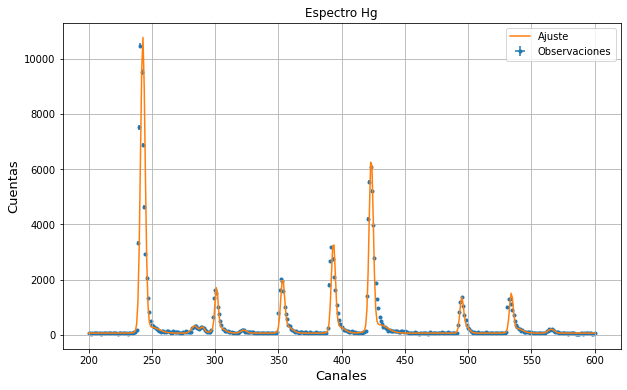

In [5]:
# Espectro de la lámpara de Hg

# tomo los datos del archivo y los cargo en un espectro
carpeta = "datos/calibracion_y_fondo/"
file_Hg = "Hg.txt"
canales_Hg, cuentas_Hg = load_file(carpeta+file_Hg)

# grafico
spec_Hg = espectro(canales_Hg, cuentas_Hg, muestra='Hg')
fig_Hg = spec_Hg.plot(errs=True,ch=True,log=False)

# ajusto 18 gaussianas para los 6 picos relevantes
# reales(nm) 253 '296' '302' 313 '334' 365 (404 '407') 435 546 (576 579)
n = 18
beta_init_Hg = [
    10000, 241, 1,
    100, 250, 3,
    100, 285, 1,
    100, 290, 1,
    1800, 300, 1,
    100, 305, 3,
    100, 320, 1,
    2000, 352, 1,
    200, 357, 3,
    3500, 393, 1,
    100, 398, 3,
    6000, 423, 1,
    100, 428, 3,
    1500, 495, 1,
    100, 500, 3,
    1500, 533, 1,
    100, 538, 3,
    100, 565, 1,
    50
]
param_Hg, err_param_Hg, chi_redof_Hg = spec_Hg.fit(gauss_n, beta_init_Hg, ch=True, use_err=True, hay_extra_args=True, n=n, group=3)

# grafico
plt.plot(spec_Hg.canales, gauss_n(param_Hg, spec_Hg.canales, n), label="Ajuste")
plt.legend()
plt.show()
# 253 '296' '302' 313 '334' 365 (404 '407') 435 546 (576 579)

pico0: 242.88030580654154 +/- 0.32872480334195125  	->	253.6517
pico1: 301.15524551639976 +/- 0.4254018500018787  	->	296.728
pico2: 353.42889664545163 +/- 0.3971148229478393  	->	365.0153
pico3: 393.503412985182 +/- 0.36678443031722874  	->	398.3931
pico4: 423.4282960496767 +/- 0.404082514360316  	->	435.8328
pico5: 534.1913002020711 +/- 0.42427140297321486  	->	546.0735

B0: -1.0534549425282747 +/- 10.849817746007533
B1: 0.9809814878050521 +/- 0.028270322636059133
chi2_red:  287.430159796134


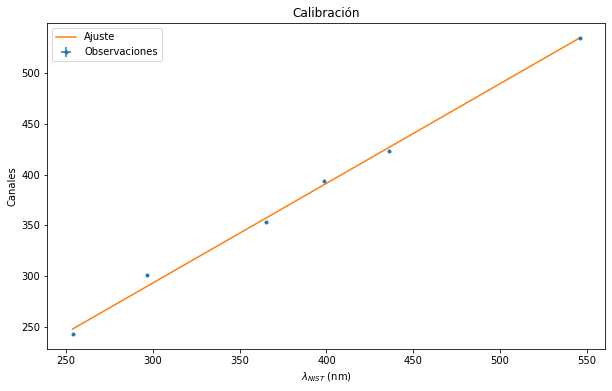

-------------------------------------------------------------------------------------
B: 0.9783212693329253 +/- 0.006236244150984319
chi2_red:  230.48613053733158


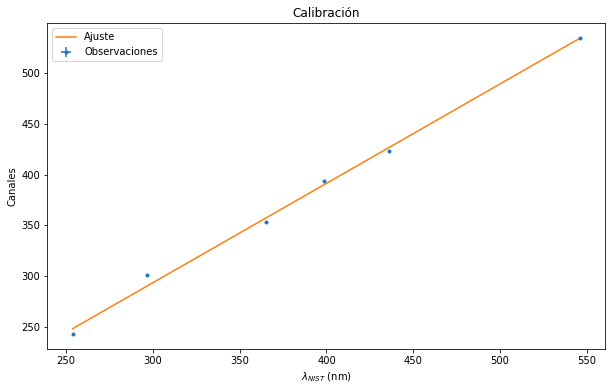

In [6]:
# CALIBRACIÓN usando el AJUSTE gaussiano para el Hg

# selecciono los picos relevantes
picos = []
err_picos = []
for i in range(3*n):
    if param_Hg[i]>1000 and i!=39:
        picos.append(param_Hg[i+1])
        err_picos.append(err_param_Hg[i+1])

# picos de referencia (NIST: https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable3.htm)
# double check (http://www.lightwindcorp.com/store/p50/HG-2_Calibration_Source_Mercury_Argon_Calibration_Source.html)
picos_nist = np.array([253.6517, 296.7280, 365.0153, 398.3931, 435.8328, 546.0735])

for i in range(len(picos)):
    print("pico{}: {} +/- {}  \t->\t{}".format(i,picos[i],err_picos[i],picos_nist[i]))
print("")

# ajuste lineal
model_fit = Model(recta_cal)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[0,1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

for i in range(2):
    print("B{}: {} +/- {}".format(i,params_cal[i],err_params_cal[i]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[5])
plt.plot(x, recta_cal(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()

print("-------------------------------------------------------------------------------------")
# ajuste lineal proporcional
model_fit = Model(prop_rel)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

print("B: {} +/- {}".format(params_cal[0],err_params_cal[0]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[5])
plt.plot(x, prop_rel(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()

pico0: 241 +/- 0.75  	->	253.6517
pico1: 285 +/- 0.75  	->	296.728
pico2: 289 +/- 0.75  	->	302.1498
pico3: 300 +/- 0.75  	->	312.9685
pico4: 323 +/- 0.75  	->	334.148
pico5: 352 +/- 0.75  	->	365.0153
pico6: 392 +/- 0.75  	->	404.6563
pico7: 423 +/- 0.75  	->	435.8328

B0: -11.906843497650732 +/- 1.6171632305948713
B1: 0.9981902479939173 +/- 0.004717194071719264
chi2_red:  1.0083096636795985


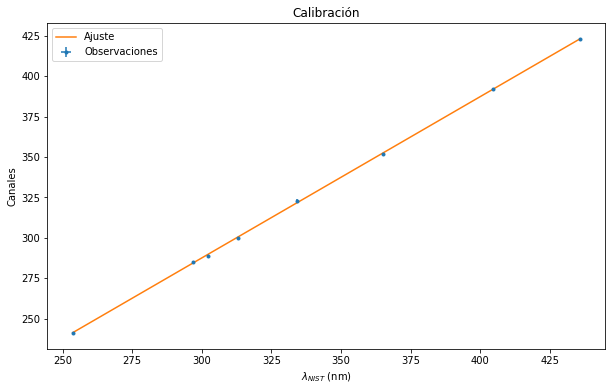

'\nprint("-------------------------------------------------------------------------------------")\n# ajuste lineal proporcional\nmodel_fit = Model(prop_rel)\ndata_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)\n\nodr_fit = ODR(data_fit, model_fit, beta0=[1])\nout = odr_fit.run()\n\nparams_cal = np.array(out.beta)\nerr_params_cal = np.array(out.sd_beta)\nchi_red_dof_cal = out.res_var\n\nprint("B: {} +/- {}".format(params_cal[0],err_params_cal[0]))\nprint("chi2_red: ",chi_red_dof_cal)\n\n# grafico\nfig_cal = plt.figure(figsize=(10,6))\nplt.title("Calibración")\n\nplt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label=\'Observaciones\', fmt=\'.\')\nx = np.linspace(picos_nist[0],picos_nist[7])\nplt.plot(x, prop_rel(params_cal,x), label=\'Ajuste\')\n\nplt.xlabel(r\'$\\lambda_{NIST}$ (nm)\')\nplt.ylabel(\'Canales\')\nplt.legend()\nplt.show()\n'

In [7]:
# CALIBRACIÓN usando los MÁXIMOS para el Hg

# busco a mano los picos relevantes
picos = np.array([241, 285, 289, 300, 323, 352, 392, 423])  #, 495, 532.5])
err_picos = np.array([0.75 for i in range(8)])

# picos de referencia (NIST: https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable3.htm)
# double check (http://www.lightwindcorp.com/store/p50/HG-2_Calibration_Source_Mercury_Argon_Calibration_Source.html)

# se tomaron promedios para los picos en 313 y en 578. el pico de 407 no se tuvo en cuenta. el pico de 334.148 no figura en NIST (???). quito los últimos dos porque da horrible.
# 253 '296' '302' 313 '334' 365 (404 '407') 435 546 (576 579)

picos_nist = np.array([253.6517, 296.7280, 302.1498, 312.9685, 334.148, 365.0153, 404.6563, 435.8328])  #, 546.0735, 578.0130])
for i in range(len(picos)):
    print("pico{}: {} +/- {}  \t->\t{}".format(i,picos[i],err_picos[i],picos_nist[i]))
print("")

# ajuste lineal
model_fit = Model(recta_cal)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[0,1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

for i in range(2):
    print("B{}: {} +/- {}".format(i,params_cal[i],err_params_cal[i]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[7])
plt.plot(x, recta_cal(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()
'''
print("-------------------------------------------------------------------------------------")
# ajuste lineal proporcional
model_fit = Model(prop_rel)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

print("B: {} +/- {}".format(params_cal[0],err_params_cal[0]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[7])
plt.plot(x, prop_rel(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()
'''

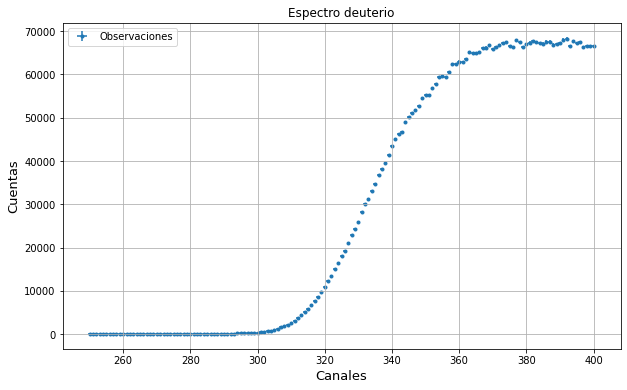

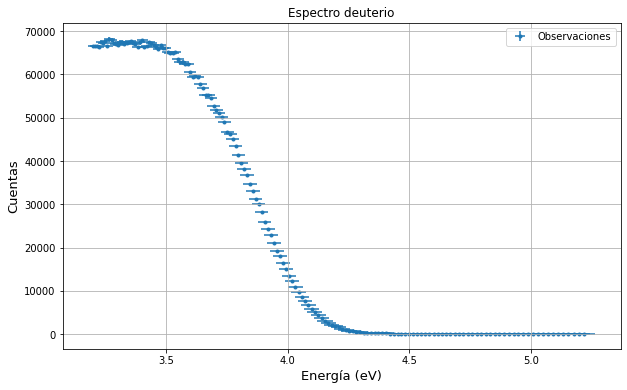

In [8]:
# FONDO usando una lámpara de deuterio

# tomo los datos del archivo y los cargo en un espectro
carpeta = "datos/calibracion_y_fondo/"
file_fondo = "deuterio.txt"
canales_fondo, cuentas_fondo = load_file(carpeta+file_fondo)

# grafico para ver cómo son
spec_fondo = espectro(canales_fondo, cuentas_fondo, muestra='deuterio')
spec_fondo.plot(errs=True,ch=True)
plt.show()

spec_fondo.calibrar(ch_to_energy, err_ch_to_energy, params_cal, err_params_cal, hay_extra_args=True, extra_args=[recta_cal,err_recta_cal])
spec_fondo.plot(errs=True)
plt.show()

In [44]:
#chequeo errores de la energía ---> son consistentes con la suma del error de la pendiente de calibración, el error aportado por el canal y una modificación por la ordenada al origen de calibración

print("error relativo porcentual de la pendiente de calibración: ", 100*err_params_cal[1]/params_cal[1],"%")
print("rango de errores relativos porcentuales de los canales: ",[100*0.5/max(spec_fondo.canales),100*0.5/min(spec_fondo.canales)],"%")

err_rel_porcentual_fondo = 100*spec_fondo.err_energia/spec_fondo.energia
ran_err_rel_porcentual_fondo = [min(err_rel_porcentual_fondo), max(err_rel_porcentual_fondo)]
print("rango de los errores relativos porcentuales de las energías: ", ran_err_rel_porcentual_fondo,"%",'\n')

dif_energia = [spec_fondo.energia[i]-spec_fondo.energia[i+1] for i in range(len(spec_fondo.energia)-1)]
ran_dif_energia = [min(dif_energia), max(dif_energia)]
ran_err_abs_energia = [min(spec_fondo.err_energia),max(spec_fondo.err_energia)]
print("rango de separaciones entre las energías: ", ran_dif_energia, "nm")
print("rango de errores absolutos de las energías: ", ran_err_abs_energia, "nm",'\n')

print("estimación mínima del \" : ", [3.1*0.513/100, 5.1*0.489/100], "nm")
aux_ran = [np.sqrt((100*0.008269/3.1)**2 - 0.125**2), np.sqrt((100*0.02182/5.1)**2 - 0.2**2)]
print("máximo error relativo porcentual permitido para la pendiente: ", min(aux_ran),"%")
print("máximo error absoluto permitido para la pendiente: ", 0.99819*min(aux_ran)/100,"nm")

error relativo porcentual de la pendiente de calibración:  0.472574650092956 %
rango de errores relativos porcentuales de los canales:  [0.125, 0.2] %
rango de los errores relativos porcentuales de las energías:  [0.6543326253531438, 0.8680242890449238] % 

rango de separaciones entre las energías:  [0.00826894144364454, 0.02182315563769155] nm
rango de errores absolutos de las energías:  [0.02094304203321313, 0.04528739702214242] nm 

estimación mínima del " :  [0.015903, 0.024938999999999996] nm
máximo error relativo porcentual permitido para la pendiente:  0.23564010725188864 %
máximo error absoluto permitido para la pendiente:  0.0023521359865776273 nm


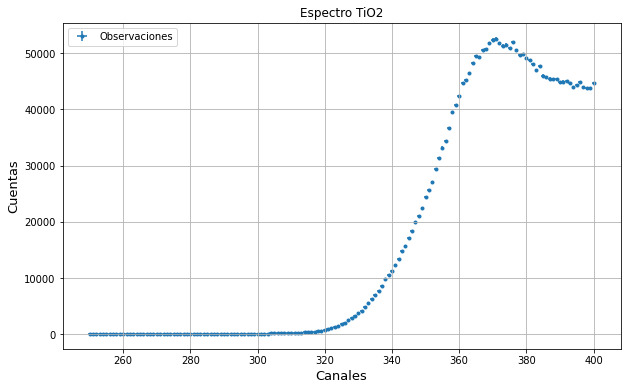

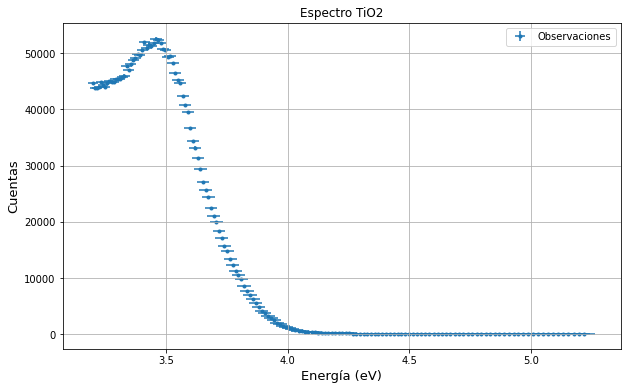

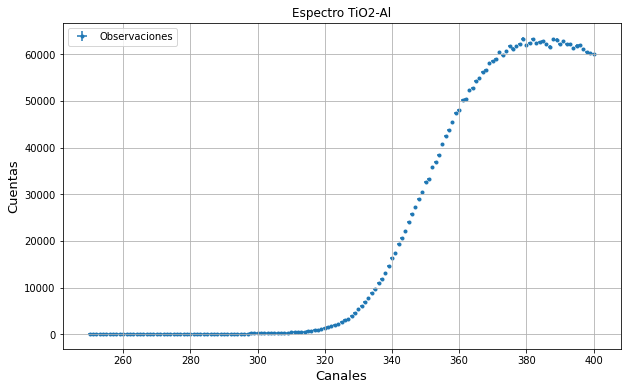

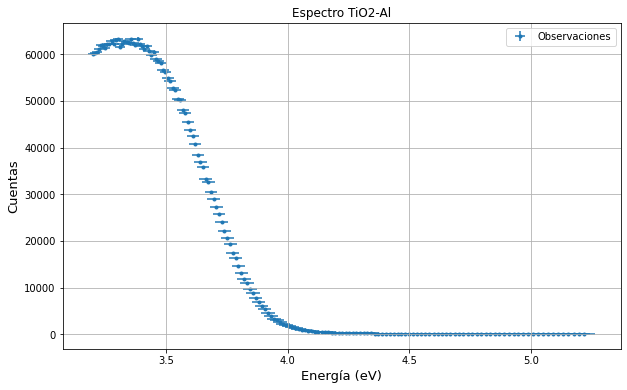

In [9]:
# espectros de las muestras y calibración

# los nombres
carpeta = "datos/"
file_names = ['TiO2.txt','TiO2-Al.txt']

specs = {}
zetas = {
    # [ztot,errztot,z0,errz0,z1,errz1...]
    'TiO2': [200e-9, 1e-9],
    'TiO2-Al': [260e-9, np.sqrt(2)*1e-9, 200e-9, 1e-9, 60e-9, 1e-9]
}

for file_name in file_names:
    # tomo los datos
    nombre_muestra = file_name.split(".")[0]
    ch_spec, cuentas_spec = load_file(carpeta+file_name)
    
    # construyo el espectro
    specs[nombre_muestra] = espectro(ch_spec, cuentas_spec, z=zetas[nombre_muestra], muestra=nombre_muestra)
    specs[nombre_muestra].plot(errs=True,ch=True)
    plt.show()

    # calibro y transformo de canales a energía
    specs[nombre_muestra].calibrar(ch_to_energy, err_ch_to_energy, params_cal, err_params_cal, hay_extra_args=True, extra_args=[recta_cal,err_recta_cal])
    fig_spec = specs[nombre_muestra].plot(errs=True)
    plt.show()

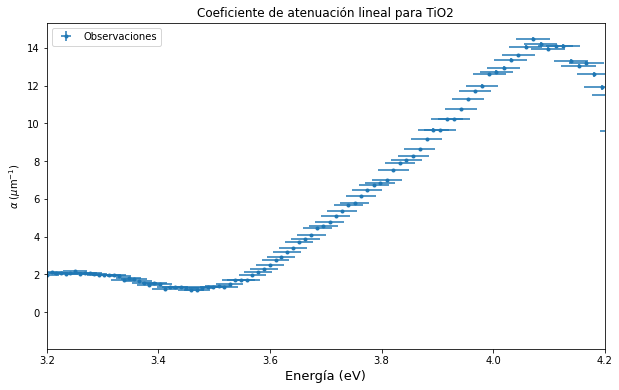

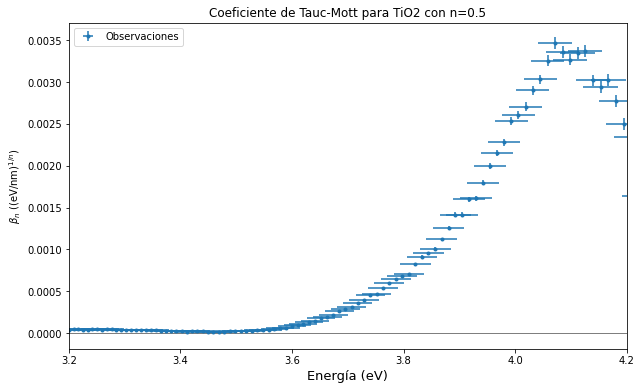

<ipython-input-2-aac964b8a863>:203: RuntimeWarning: invalid value encountered in power
  return (self.alpha*self.energia)**(1/n)


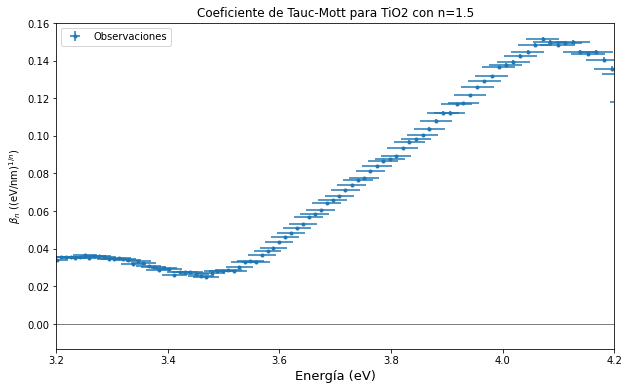

<ipython-input-2-aac964b8a863>:203: RuntimeWarning: invalid value encountered in sqrt
  return (self.alpha*self.energia)**(1/n)


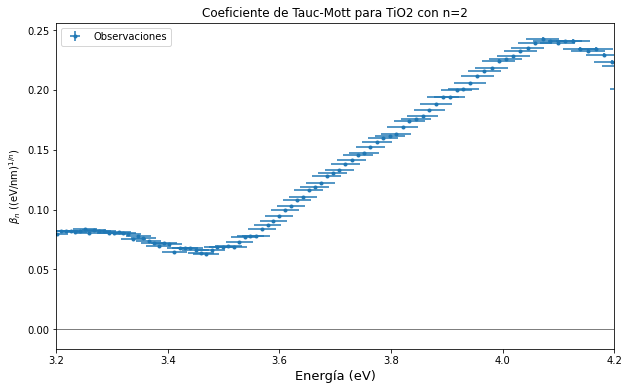

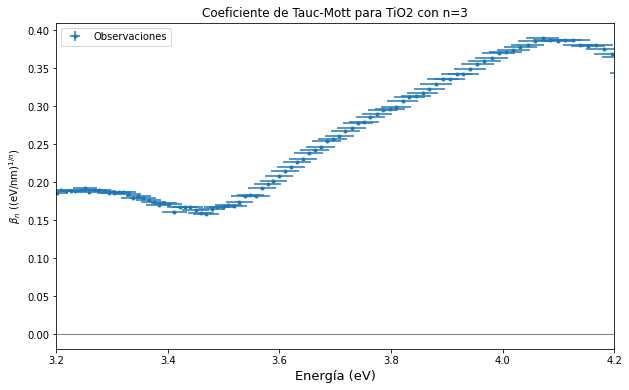

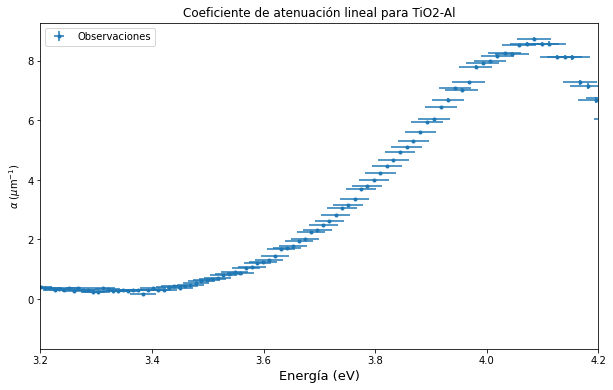

<ipython-input-2-aac964b8a863>:206: RuntimeWarning: divide by zero encountered in true_divide
  return self.beta_n_values(n)*np.sqrt((self.err_alpha/self.alpha)**2 + (self.err_energia/self.energia)**2)/n
<ipython-input-2-aac964b8a863>:206: RuntimeWarning: invalid value encountered in multiply
  return self.beta_n_values(n)*np.sqrt((self.err_alpha/self.alpha)**2 + (self.err_energia/self.energia)**2)/n


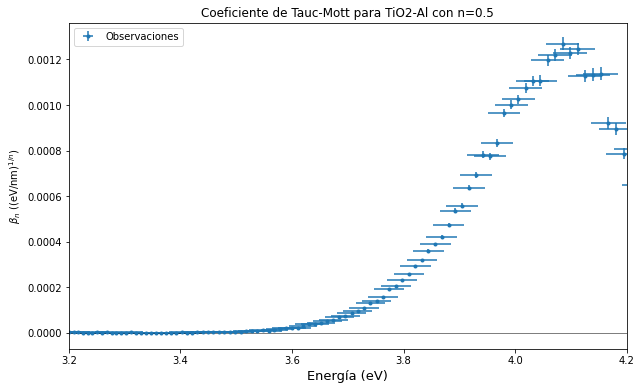

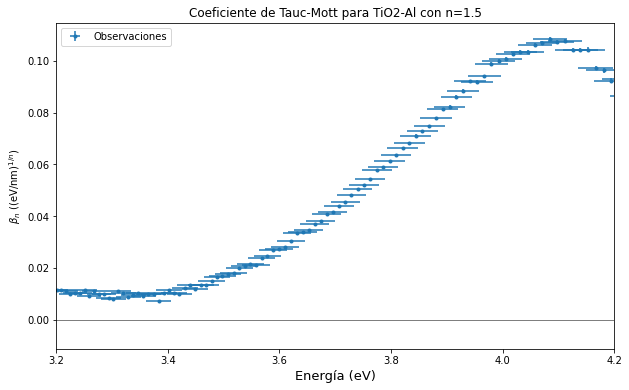

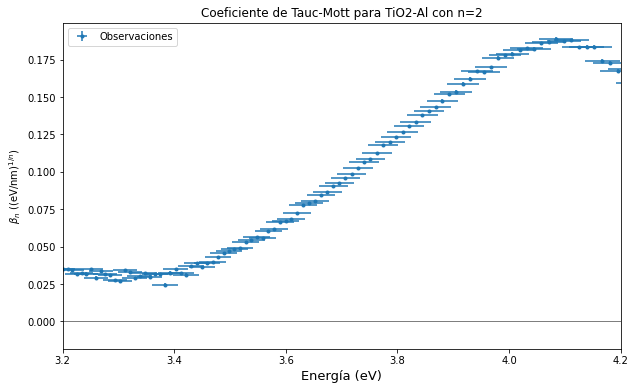

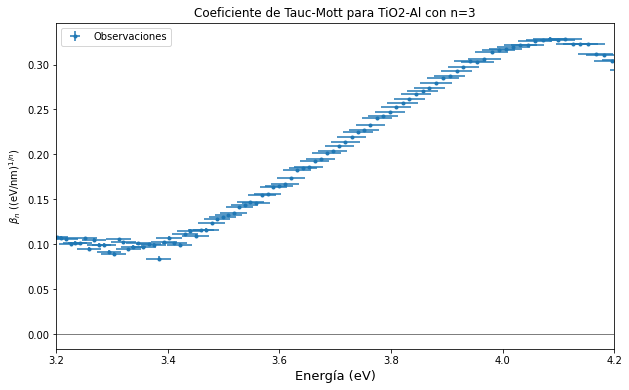

In [10]:
# Análisis de Tauc-Mott para distintos n
n_values = [0.5, 1.5, 2, 3]

for muestra in specs:
    specs[muestra].calculate_alpha(spec_fondo.cuentas,spec_fondo.err_cuentas)
    fig_alpha = specs[muestra].plot_alpha(errs=True)
    plt.xlim(3.2,4.2)
    plt.show()

    for n in n_values:
        specs[muestra].calculate_beta_n(n)
        fig_beta_n = specs[muestra].plot_beta_n(n,errs=True)
        plt.xlim(3.2,4.2)
        plt.show()